In [1]:
# !open .

In [2]:
import pandas as pd
import requests
import bs4
import math
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import NeoQuant as nq

## get all company list

In [3]:
companies = nq.get_all_company_list()
companies.index = 'A' + companies.index

## bond spread

In [4]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

## load basic dataframe from excel

In [5]:
basic_df = pd.read_excel(r'data/basic_data.xlsx')
basic_df.index = basic_df[basic_df.columns[0]]
basic_df.index.name = ''
basic_df.drop(basic_df.columns[0], axis = 1, inplace = True)

## load fr dataframe from excel

In [6]:
fr_df = pd.read_excel(r'data/fr_data.xlsx')
fr_df.index = fr_df[fr_df.columns[0]]
fr_df.index.name = ''
fr_df.drop(fr_df.columns[0], axis = 1, inplace = True)
big_col = list(fr_df.columns)
small_col = list(fr_df.iloc[0])

new_big_col = []
for num, col in enumerate(big_col):
    if 'Unnamed' in col:
        new_big_col.append(new_big_col[num-1])
    else:
        new_big_col.append(big_col[num])

fr_df.columns = [new_big_col, small_col]
fr_df = fr_df.loc[ fr_df.index.dropna() ]

In [7]:
company_name_list = ['DB금융투자', 'KTB투자증권', '대신증권', '한화투자증권', '신영증권', '한양증권',
                    '유안타증권', '코리아에셋투자증권', '교보증권', '현대차증권', '삼성증권', '유화증권', 
                    '상상인증권', 'NH투자증권', '한국금융지주', '이베스트투자증권', '부국증권', 'SK증권',
                    '유진증권', '메리츠증권', '다우데이타', '키움증권', '미래에셋대우']

In [8]:
company_code_list = []
for name in company_name_list:
    company_code = nq.get_company_code(name, companies)
    company_code_list.append(company_code)
company_code_list

['A016610',
 'A030210',
 'A003540',
 'A003530',
 'A001720',
 'A001750',
 'A003470',
 'A190650',
 'A030610',
 'A001500',
 'A016360',
 'A003460',
 'A001290',
 'A005940',
 'A071050',
 'A078020',
 'A001270',
 'A001510',
 'A001200',
 'A008560',
 'A032190',
 'A039490',
 'A006800']

In [9]:
sector_df = basic_df.loc[company_code_list]

## calculate adequate price

In [10]:
total = len(sector_df)

for num, code in enumerate(sector_df.index):
    company_name = nq.get_company_name(code, companies)
    print(str(num + 1) + ' / ' + str(total) + " : " + company_name + ' (' + str(code) + ')')

#     print(num, code, company_name)
    for col in reversed(fr_df.columns.levels[0]):
#         print(fr_df[col]['ROE'])
        try:
            roe = pd.to_numeric(fr_df.loc[code][col]['ROE'])
            per = pd.to_numeric(fr_df.loc[code][col]['PER'])
            pbr = pd.to_numeric(fr_df.loc[code][col]['PBR'])
            asset = pd.to_numeric(fr_df.loc[code][col]['지배주주지분']) * 100000000
            debt_rate = pd.to_numeric(fr_df.loc[code][col]['부채비율'])
            keep_rate = pd.to_numeric(fr_df.loc[code][col]['유보율'])
            interest_rate = pd.to_numeric(fr_df.loc[code][col]['배당수익률'])

                
            if not math.isnan(roe) and not math.isnan(asset):
                print('standard date : ' + col)
                stock_count = sector_df.loc[code]['주식수']
                sector_df.at[code, '기준일'] = col
                sector_df.at[code, 'roe'] = roe
                sector_df.at[code, 'per'] = per
                sector_df.at[code, 'pbr'] = pbr
                sector_df.at[code, '부채비율'] = debt_rate
                sector_df.at[code, '유보율'] = keep_rate
                sector_df.at[code, '배당수익률'] = interest_rate
                
                sector_df.at[code, 'expectation'] = expected_ratio
    #             print('stock_count : ' + str(stock_count))
                high = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    #             print('high : ' + str(high))
                sector_df.at[code, 'high'] = high
                middle = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
                sector_df.at[code, 'middle'] = middle
                low = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)
                sector_df.at[code, 'low'] = low
                very_low = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.5)
                sector_df.at[code, 'very_low'] = very_low
                break
        except ValueError:
            print('>>> ValueError')
            continue


sector_df['dis_rate'] = sector_df['price'] / sector_df['low']
sector_df = sector_df.sort_values(by='dis_rate', ascending=True)
sector_df['rank'] = sector_df['dis_rate'].rank()

1 / 23 : DB금융투자 (A016610)
standard date : 2019/12
2 / 23 : KTB투자증권 (A030210)
standard date : 2019/12
3 / 23 : 대신증권 (A003540)
standard date : 2019/12
4 / 23 : 한화투자증권 (A003530)
standard date : 2019/12
5 / 23 : 신영증권 (A001720)
standard date : 2020/03
6 / 23 : 한양증권 (A001750)
standard date : 2019/12
7 / 23 : 유안타증권 (A003470)
standard date : 2019/12
8 / 23 : 코리아에셋투자증권 (A190650)
standard date : 2020/03
9 / 23 : 교보증권 (A030610)
standard date : 2019/12
10 / 23 : 현대차증권 (A001500)
standard date : 2019/12
11 / 23 : 삼성증권 (A016360)
standard date : 2019/12
12 / 23 : 유화증권 (A003460)
standard date : 2019/12
13 / 23 : 상상인증권 (A001290)
standard date : 2019/12
14 / 23 : NH투자증권 (A005940)
standard date : 2019/12
15 / 23 : 한국금융지주 (A071050)
standard date : 2019/12
16 / 23 : 이베스트투자증권 (A078020)
standard date : 2019/12
17 / 23 : 부국증권 (A001270)
standard date : 2019/12
18 / 23 : SK증권 (A001510)
standard date : 2019/12
19 / 23 : 유진증권 (A001200)
standard date : 2019/12
20 / 23 : 메리츠증권 (A008560)
standard date : 2019/12
21 / 

In [11]:
sector_df.to_excel(r'data/stock_sector.xlsx')

In [12]:
sector_df = pd.read_excel(r'data/stock_sector.xlsx')
sector_df.index = sector_df[sector_df.columns[0]]
sector_df.index.name = ''
sector_df.drop(sector_df.columns[0], axis = 1, inplace = True)

## 수익률 계산

In [13]:
port_df = sector_df

In [14]:
import time

port_list = port_df.index
total = len(port_list)
for num, company_code in enumerate(port_list):
    company_name = nq.get_company_name(company_code, companies)
    print(str(num + 1) + ' / ' + str(total) + " : " + company_name + ' (' + str(company_code) + ')')
    time.sleep(1)
    try:
        price_df = nq.request_price_list(company_code, 'day', 100)
    except requests.exceptions.Timeout:
        time.sleep(60)
        price_df = nq.request_price_list(company_code, 'day', 100)
        
    current = price_df[price_df.columns[0]][-1]
    port_df.at[company_code, 'current'] = int(current)

1 / 23 : DB금융투자 (A016610)
2 / 23 : 유화증권 (A003460)
3 / 23 : 부국증권 (A001270)
4 / 23 : 교보증권 (A030610)
5 / 23 : 한양증권 (A001750)
6 / 23 : KTB투자증권 (A030210)
7 / 23 : 현대차증권 (A001500)
8 / 23 : 한화투자증권 (A003530)
9 / 23 : 유진증권 (A001200)
10 / 23 : 메리츠증권 (A008560)
11 / 23 : 유안타증권 (A003470)
12 / 23 : 대신증권 (A003540)
13 / 23 : NH투자증권 (A005940)
14 / 23 : 코리아에셋투자증권 (A190650)
15 / 23 : 다우데이타 (A032190)
16 / 23 : 삼성증권 (A016360)
17 / 23 : 미래에셋대우 (A006800)
18 / 23 : SK증권 (A001510)
19 / 23 : 한국금융지주 (A071050)
20 / 23 : 이베스트투자증권 (A078020)
21 / 23 : 신영증권 (A001720)
22 / 23 : 상상인증권 (A001290)
23 / 23 : 키움증권 (A039490)


In [15]:
profit_rate = (port_df['current'] - port_df['price']) / port_df['price']
profit_rate = profit_rate.dropna()
profit_rate = profit_rate.map(lambda rate: str("%.2f" % round(float(rate * 100), 2)) + '%')
port_df['수익률'] = profit_rate

In [16]:
profit_rate = port_df['수익률'].map(lambda rate: float(rate[:-1]))
average_profit = profit_rate.sum() / len(port_df)
print('average profit : ' + "%.2f" % average_profit + '%')

average profit : 0.00%


In [21]:
port_df.to_excel(r'data/stock_sector_profit.xlsx')

## show chart

In [17]:
company_code_list = port_df.index

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


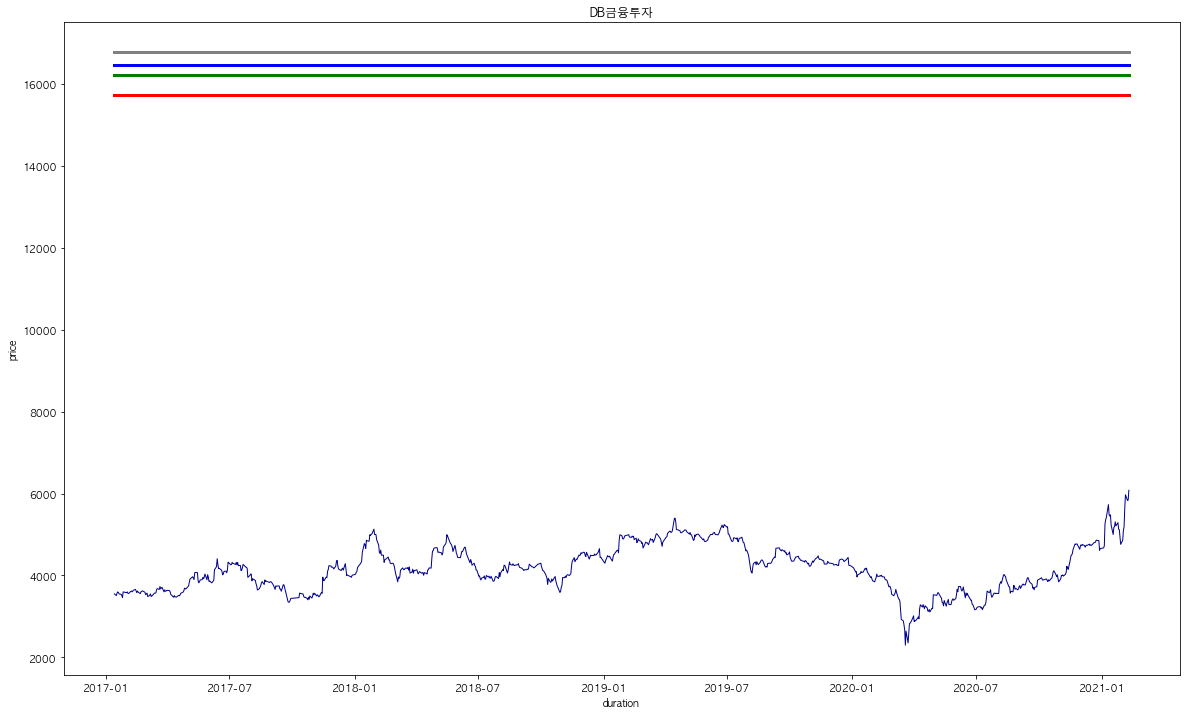

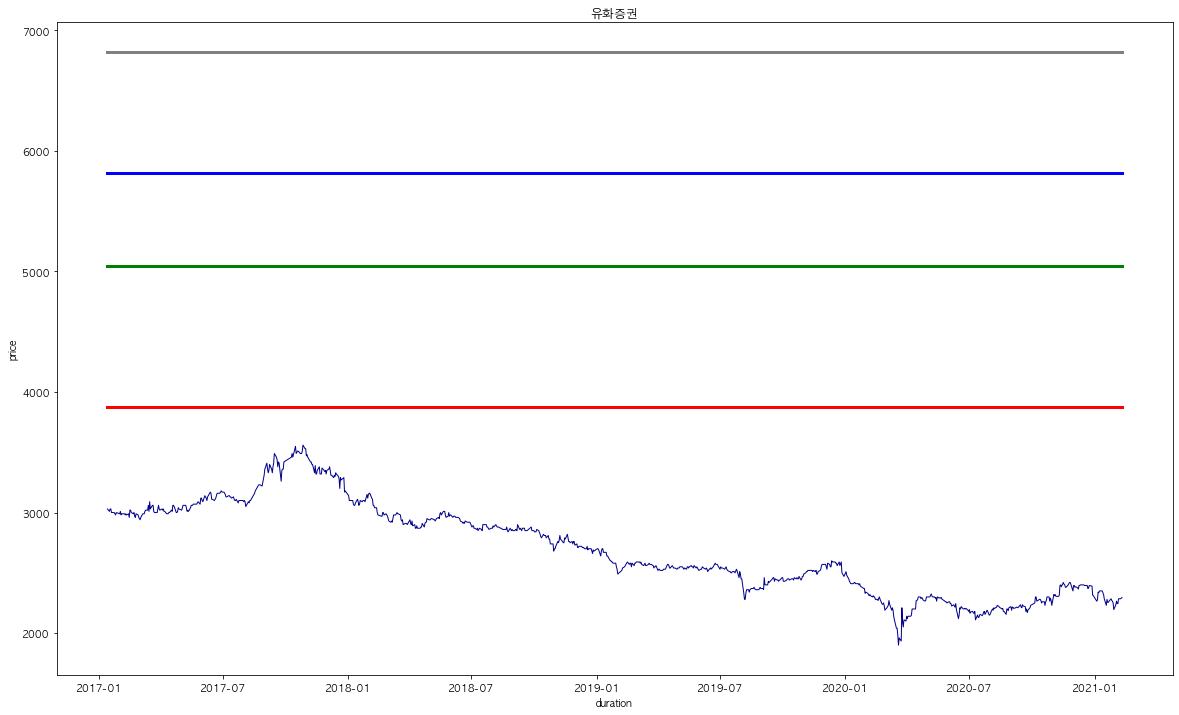

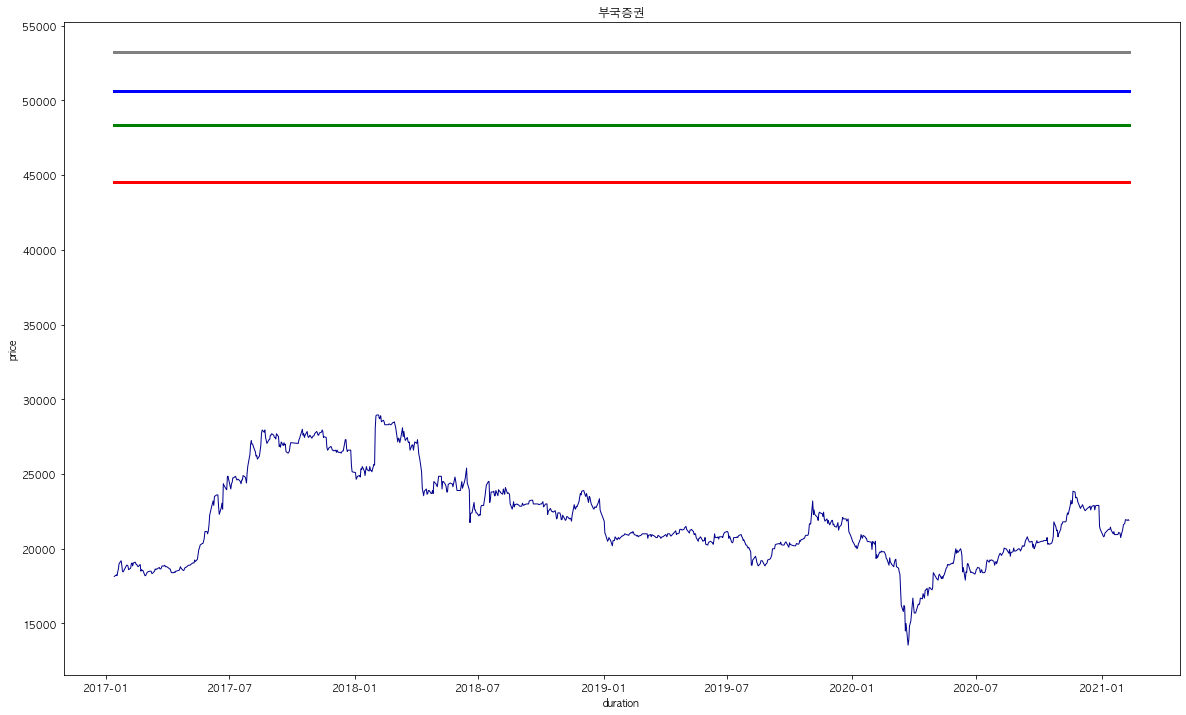

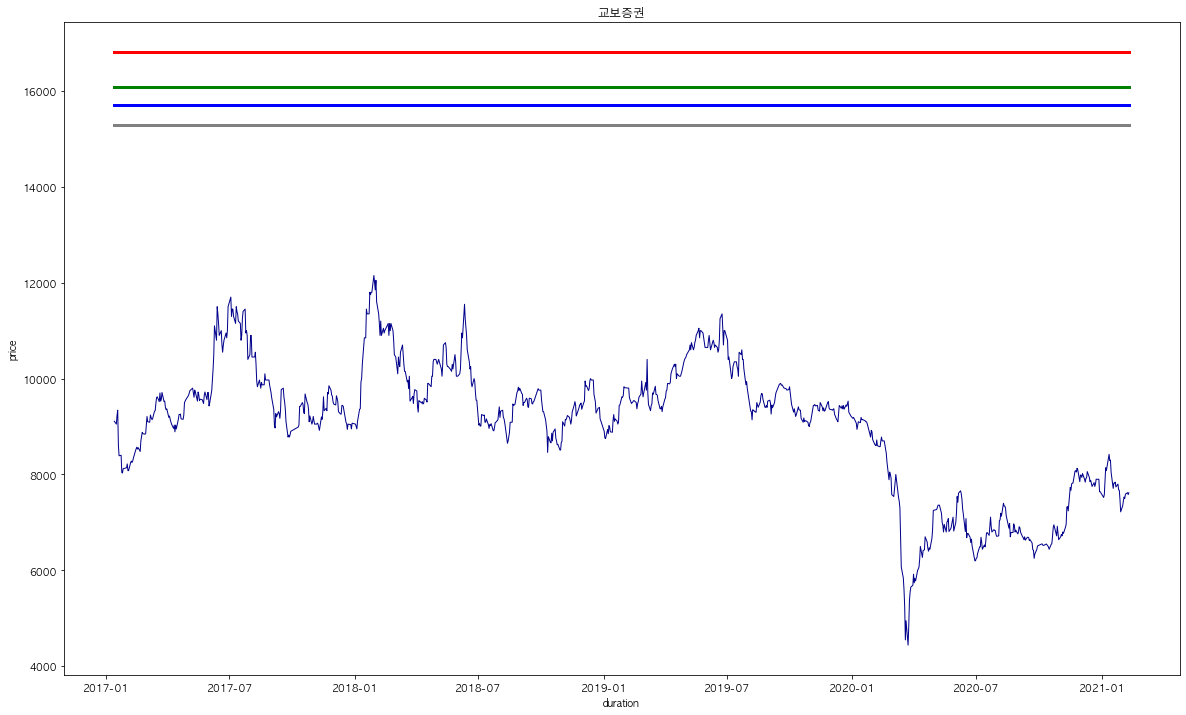

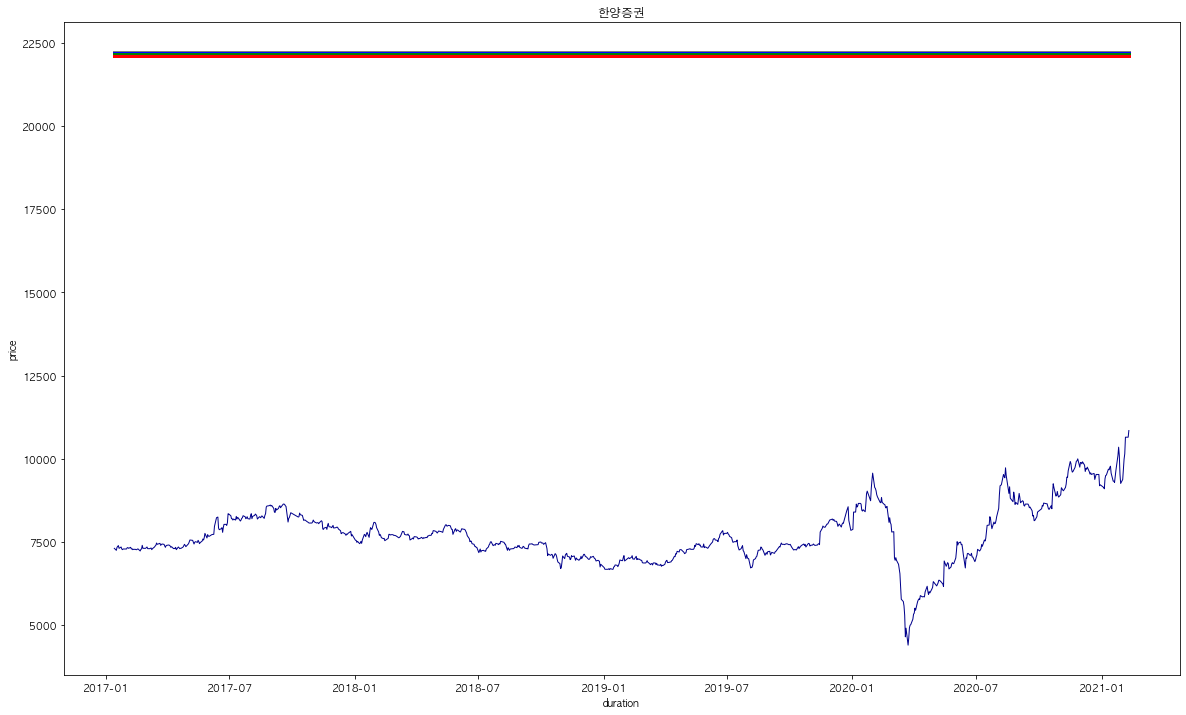

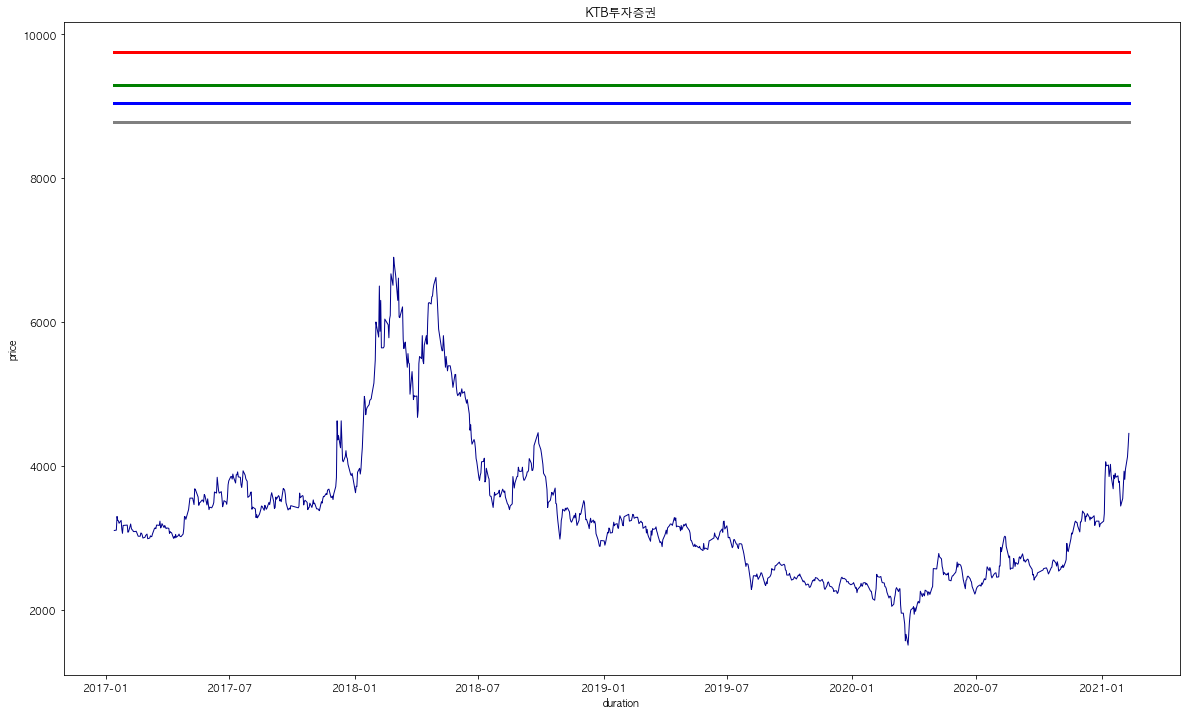

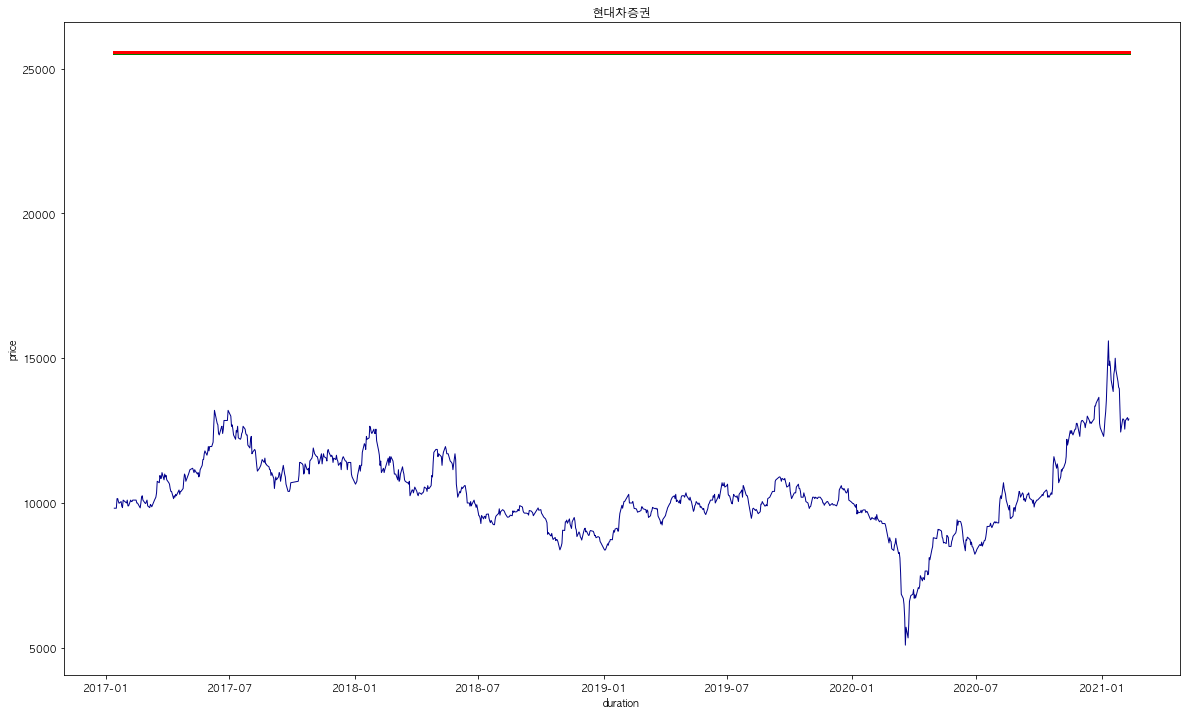

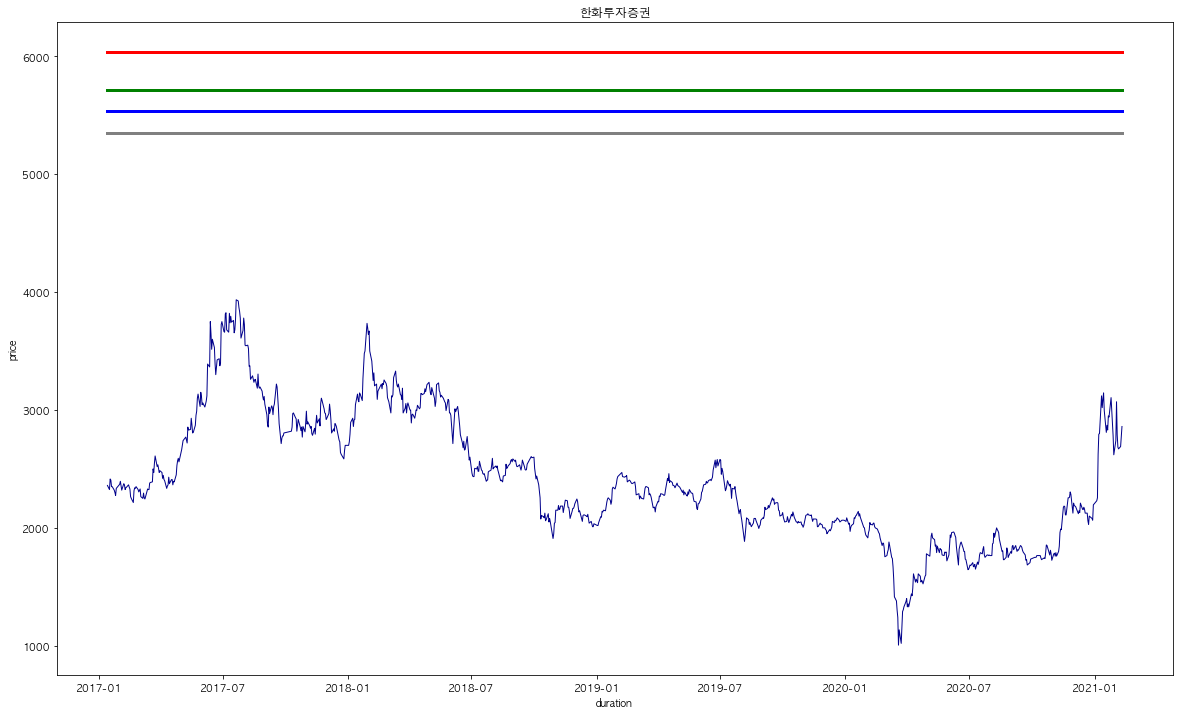

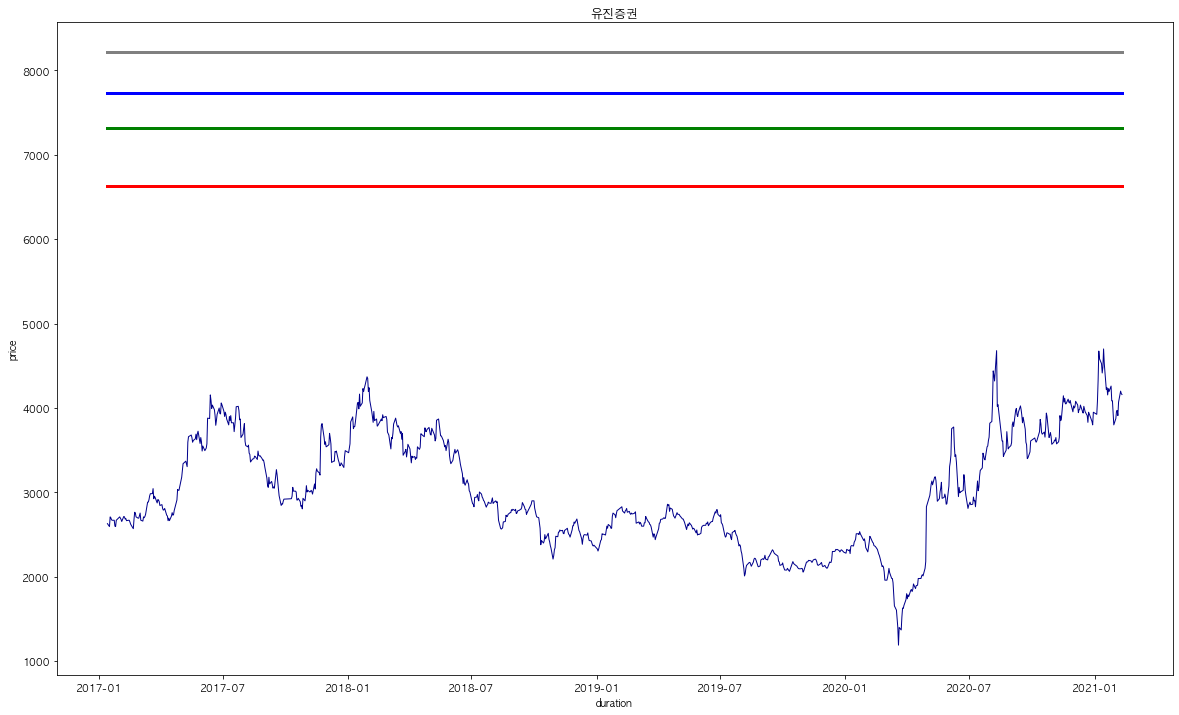

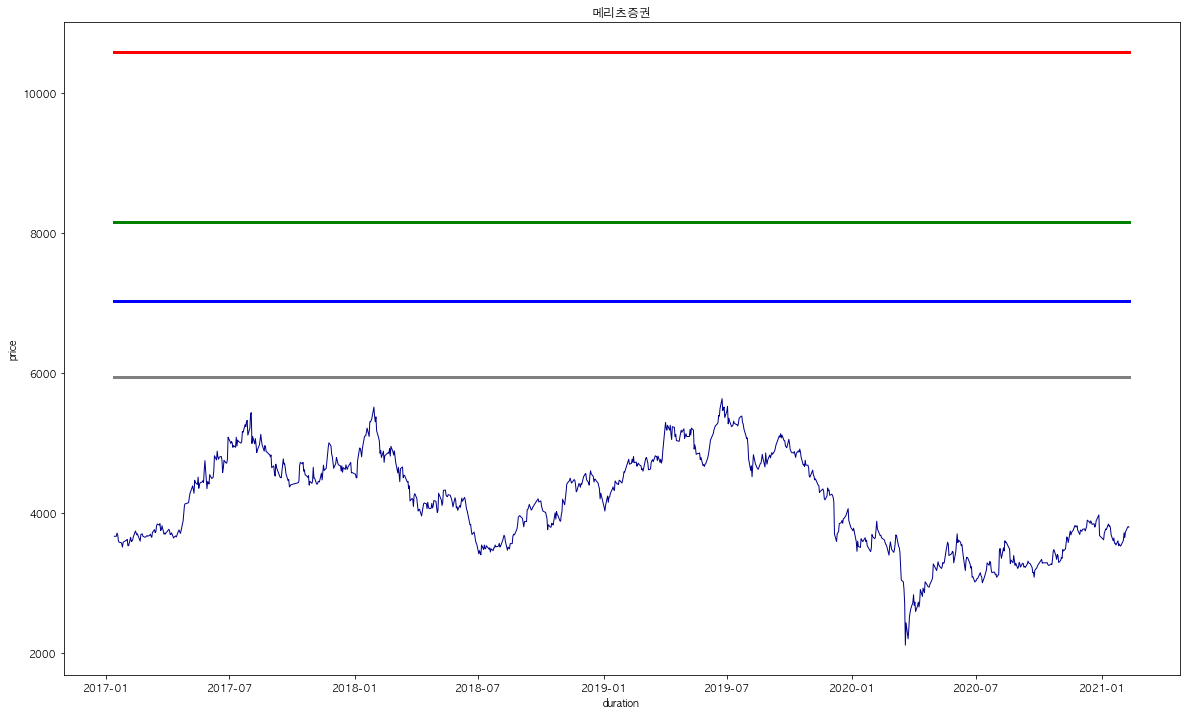

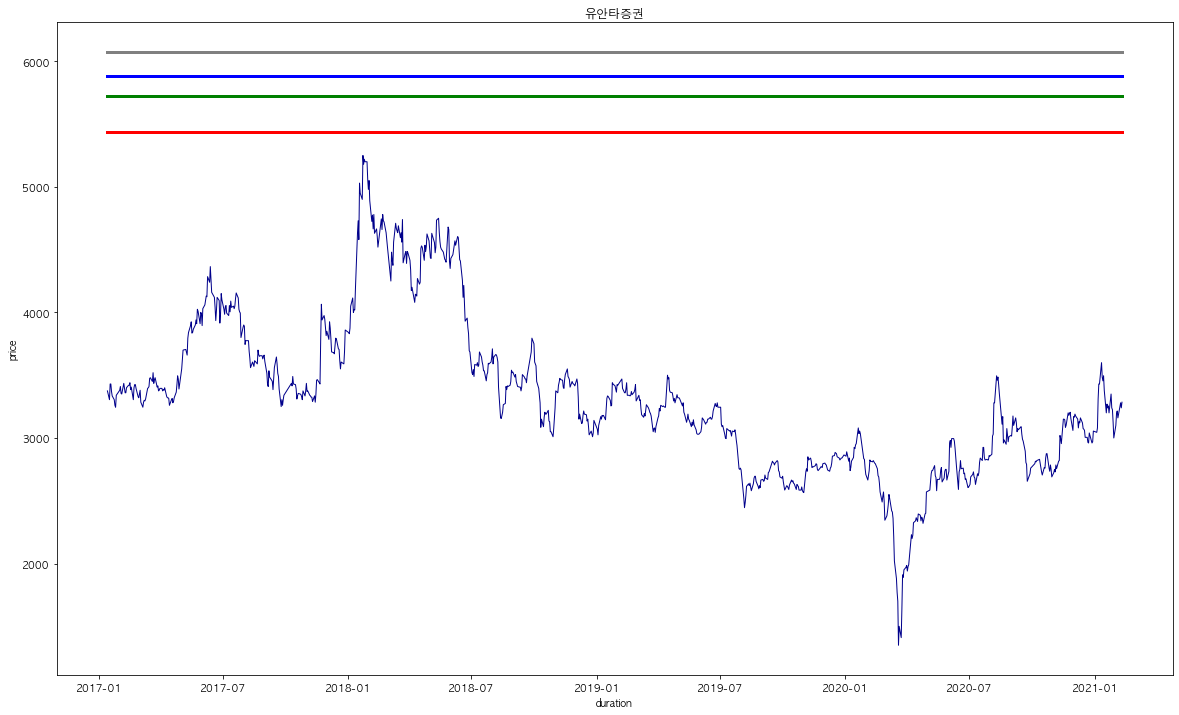

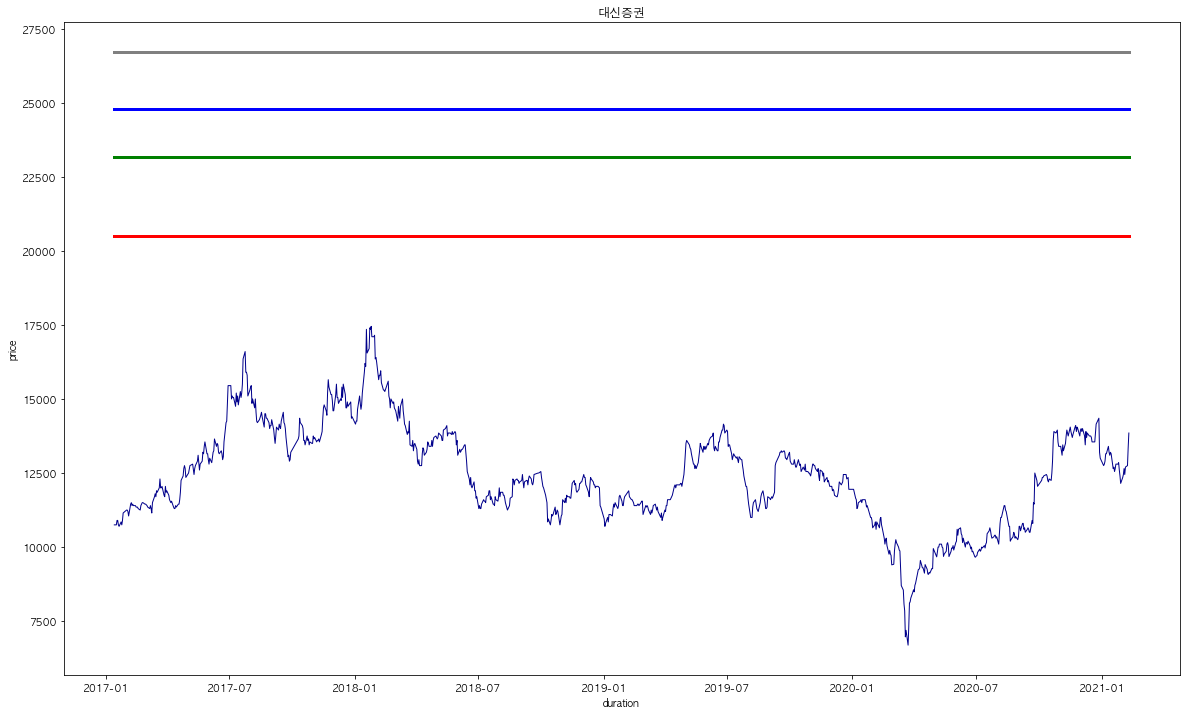

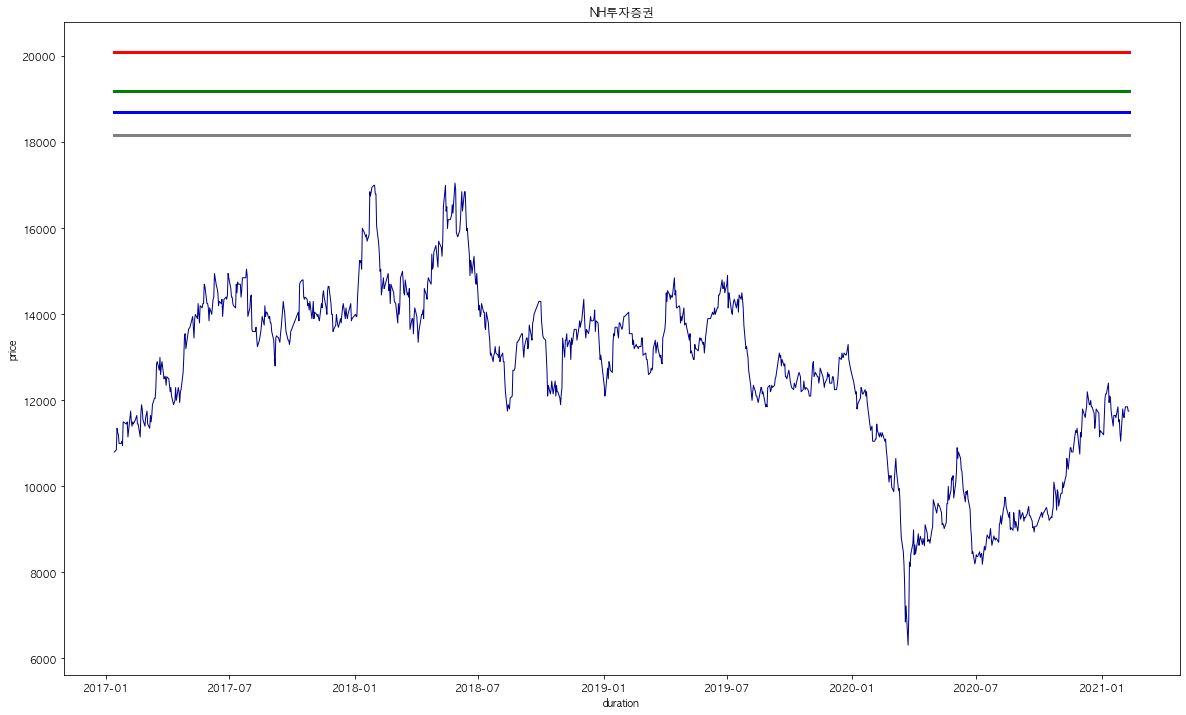

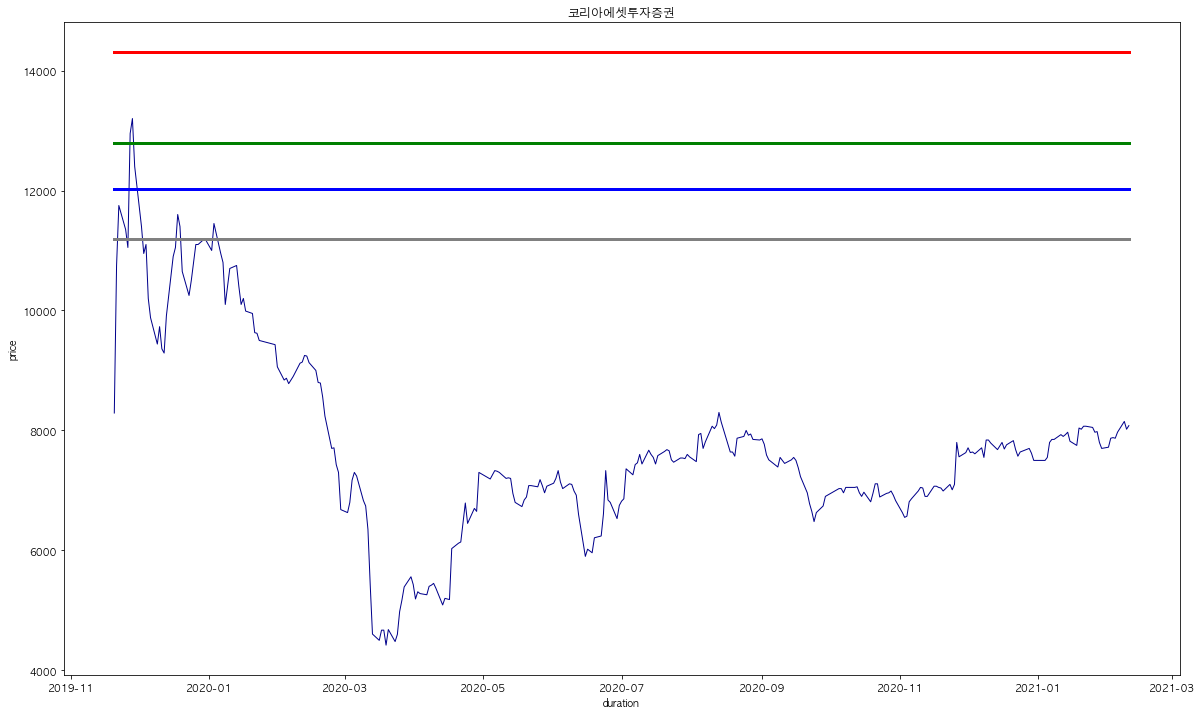

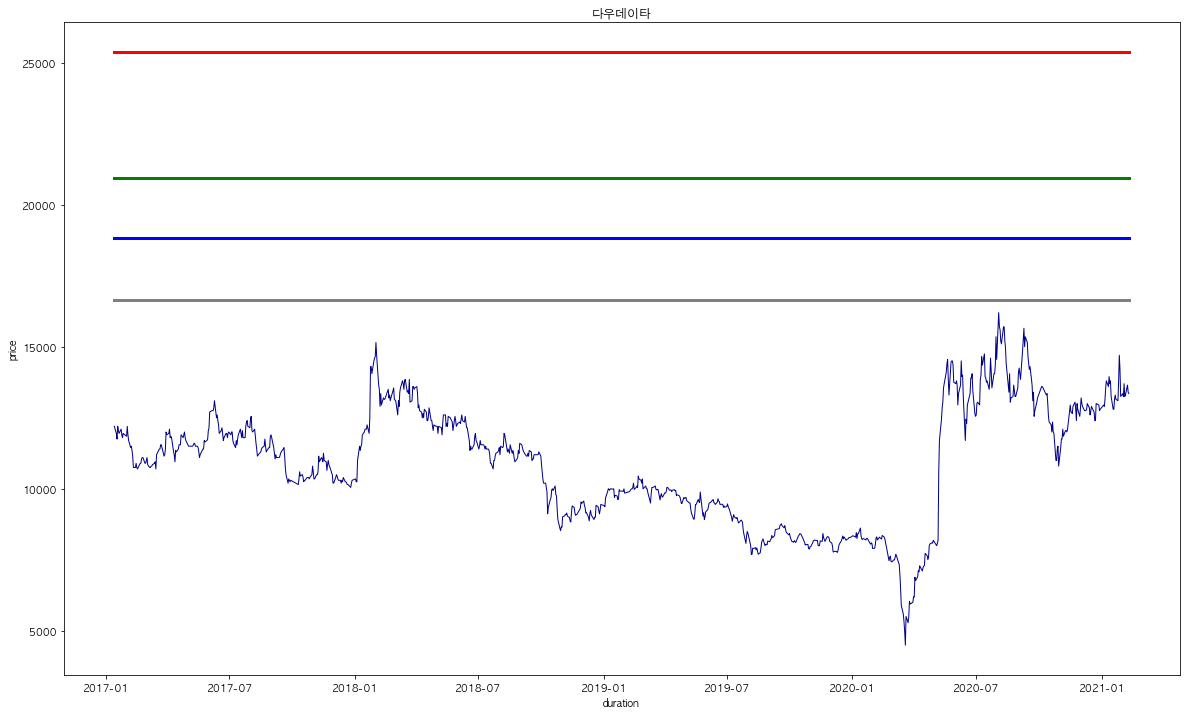

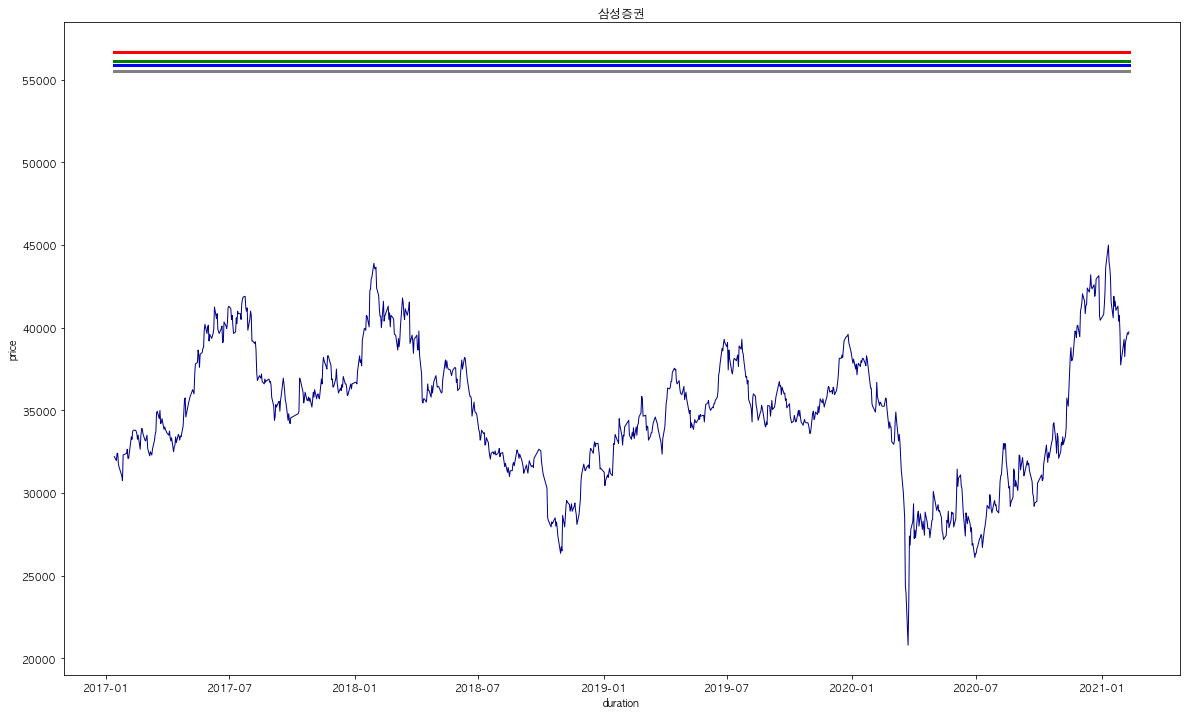

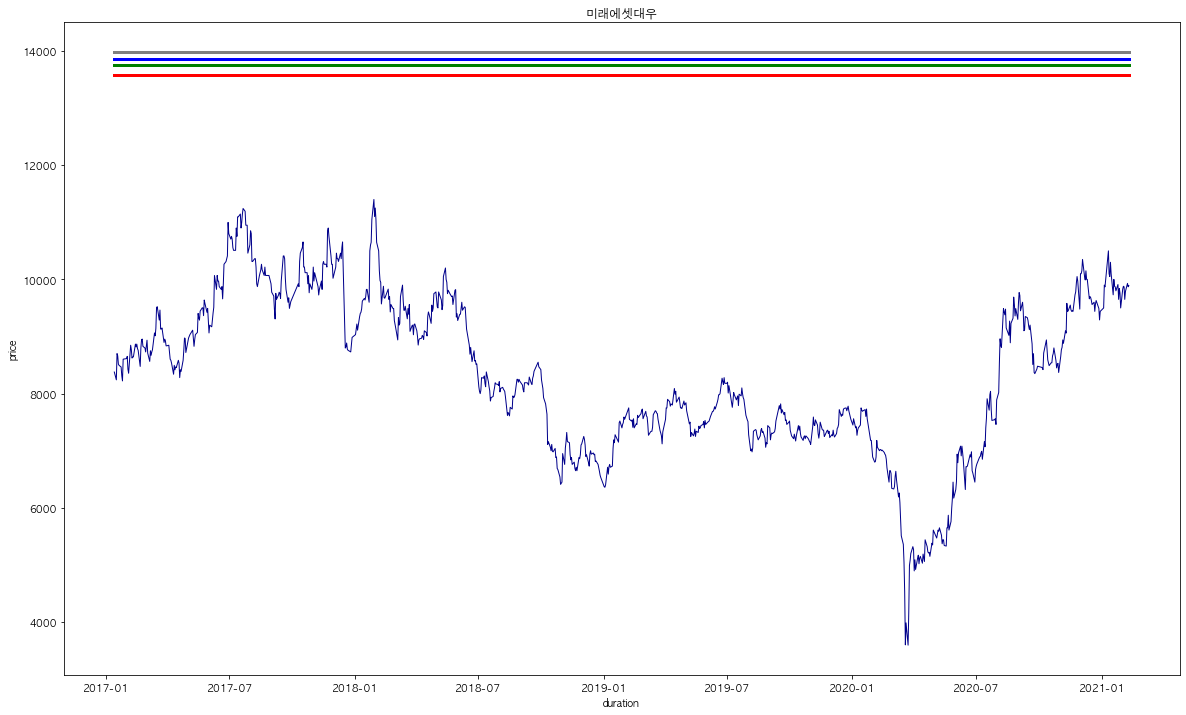

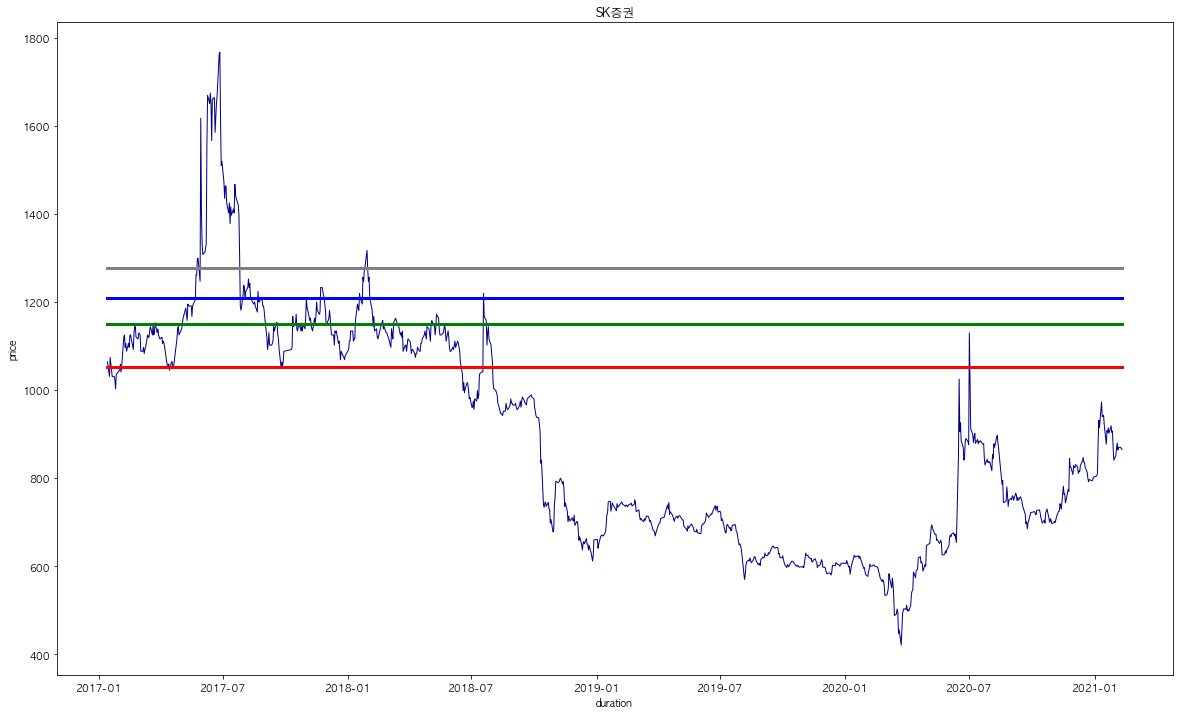

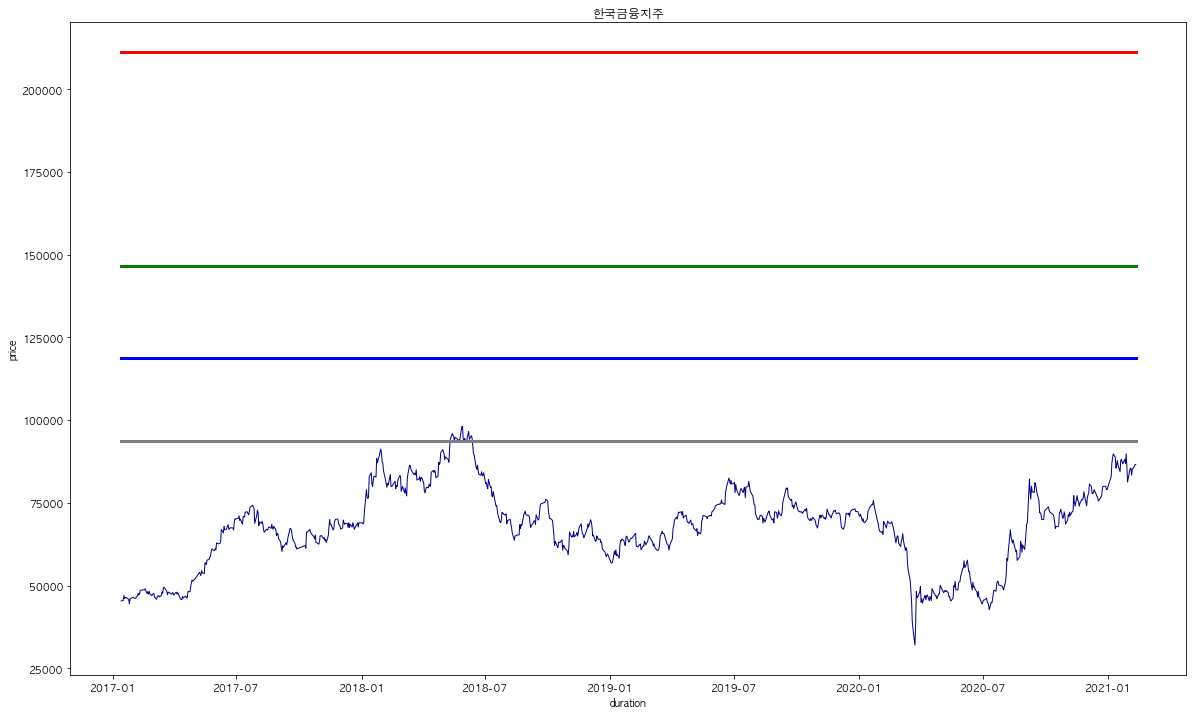

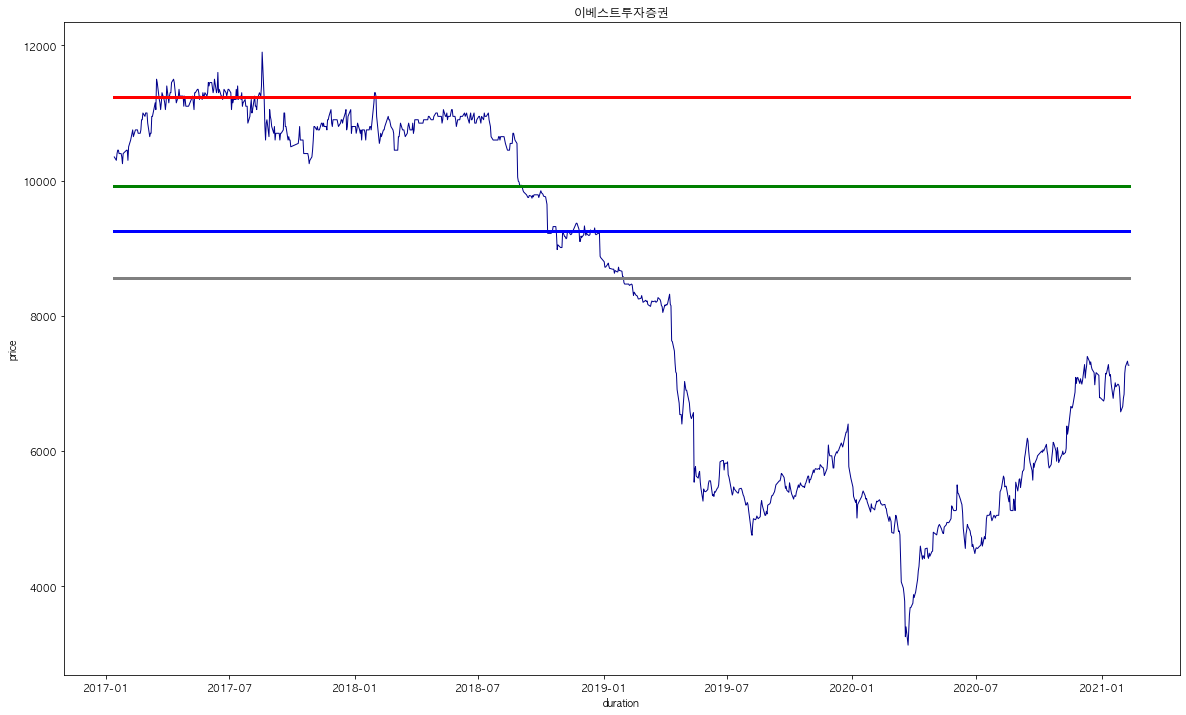

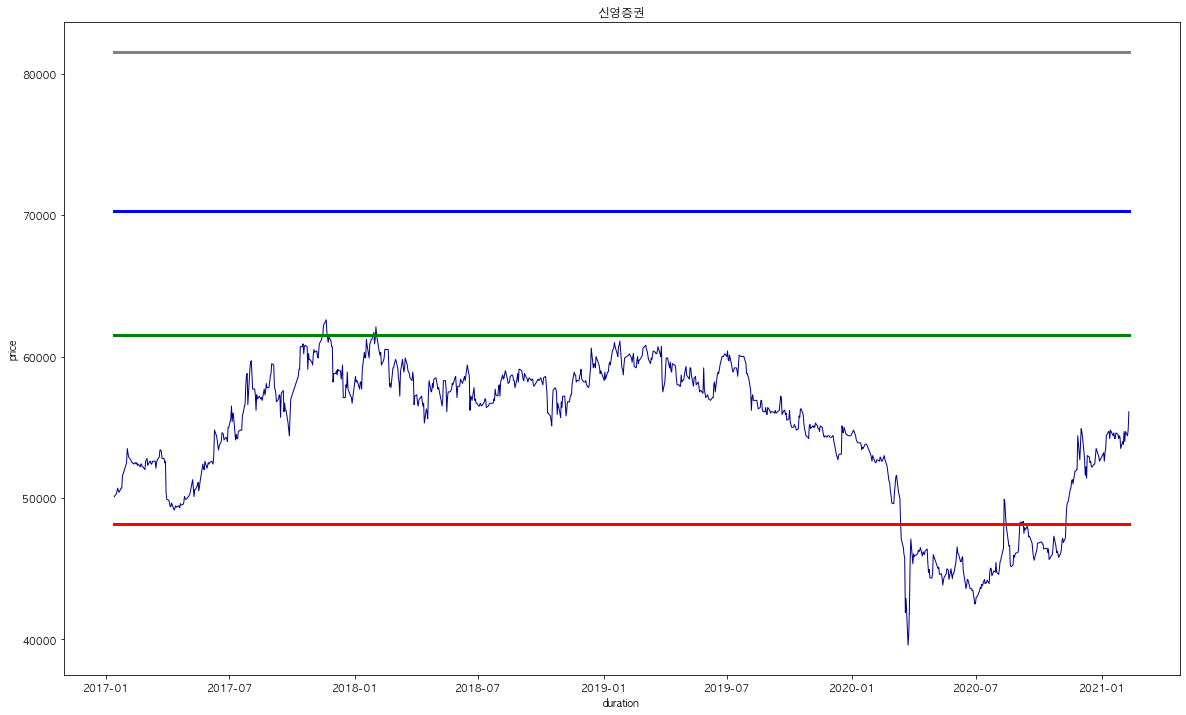

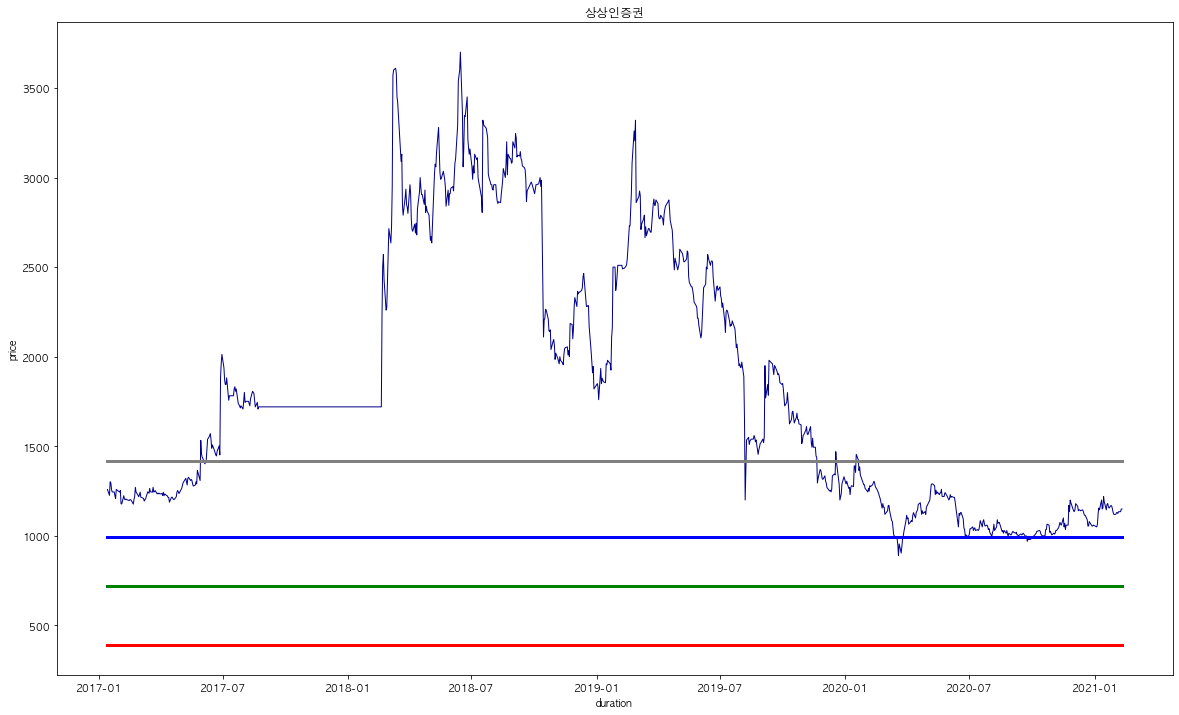

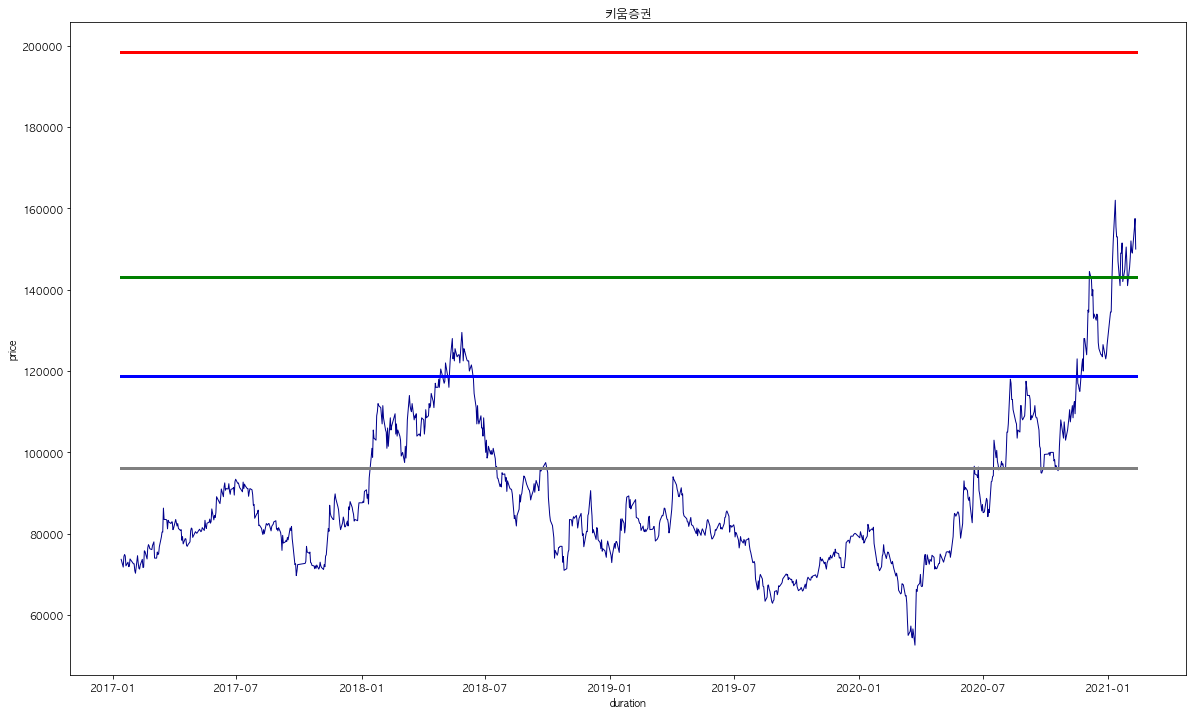

In [18]:
for company_code in company_code_list:
    company_name = nq.get_company_name(company_code, companies)

    price_df = nq.request_price_list(company_code, 'day', 1000)

    price_high = sector_df.loc[company_code]['high']
    price_middle = sector_df.loc[company_code]['middle']
    price_low = sector_df.loc[company_code]['low']
    price_very_low = sector_df.loc[company_code]['very_low']

    price_df['price_very_low'] = [price_very_low] * len(price_df)
    price_df['price_low'] = [price_low] * len(price_df)
    price_df['price_middle'] = [price_middle] * len(price_df)
    price_df['price_high'] = [price_high] * len(price_df)

    nq.show_price_chart(company_code, company_name, price_df)